In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import MaxNLocator
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)
import copy

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
input_shape = (28, 28, 1)

In [3]:
def create_train_test_buckets(x_train, y_train, x_test, y_test):
    '''
    
    '''
    partitioned_train_arrays = {}
    numpy_partitioned_train_arrays = {}

    train_mix_fraction = 0.8
    test_mix_fraction = 0.8

    train_mix_length = int(len(x_train)*train_mix_fraction)
    test_mix_length = int(len(x_test)*test_mix_fraction)

    for item in zip(x_train,y_train):
        partitioned_train_arrays[item[1]]=([],[])

    for item in zip(x_train[:train_mix_length],y_train[:train_mix_length]):
        partitioned_train_arrays[item[1]][0].append(item[0])
        partitioned_train_arrays[item[1]][1].append(item[1])

    for item in zip(x_train[train_mix_length:],y_train[train_mix_length:]):
        random_bucket = int(np.random.randint(0,10,1))
        partitioned_train_arrays[random_bucket][0].append(item[0])
        partitioned_train_arrays[random_bucket][1].append(item[1])

    for item in partitioned_train_arrays:
        numpy_partitioned_train_arrays[item] = (np.array(partitioned_train_arrays[item][0]), np.array(partitioned_train_arrays[item][1]))

        
    partitioned_test_arrays = {}
    numpy_partitioned_test_arrays = {}


    for item in zip(x_test,y_test):
        partitioned_test_arrays[item[1]]=([],[])

    for item in zip(x_test[:test_mix_length],y_test[:test_mix_length]):
        partitioned_test_arrays[item[1]][0].append(item[0])
        partitioned_test_arrays[item[1]][1].append(item[1])

    for item in zip(x_test[test_mix_length:],y_test[test_mix_length:]):
        random_bucket = int(np.random.randint(0,10))
        partitioned_test_arrays[random_bucket][0].append(item[0])
        partitioned_test_arrays[random_bucket][1].append(item[1])


    for item in partitioned_test_arrays:
        partitioned_test_arrays[item] = (np.array(partitioned_test_arrays[item][0]), np.array(partitioned_test_arrays[item][1]))

    return(numpy_partitioned_train_arrays, partitioned_test_arrays)

In [4]:
partitioned_train_arrays, partitioned_test_arrays = create_train_test_buckets(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


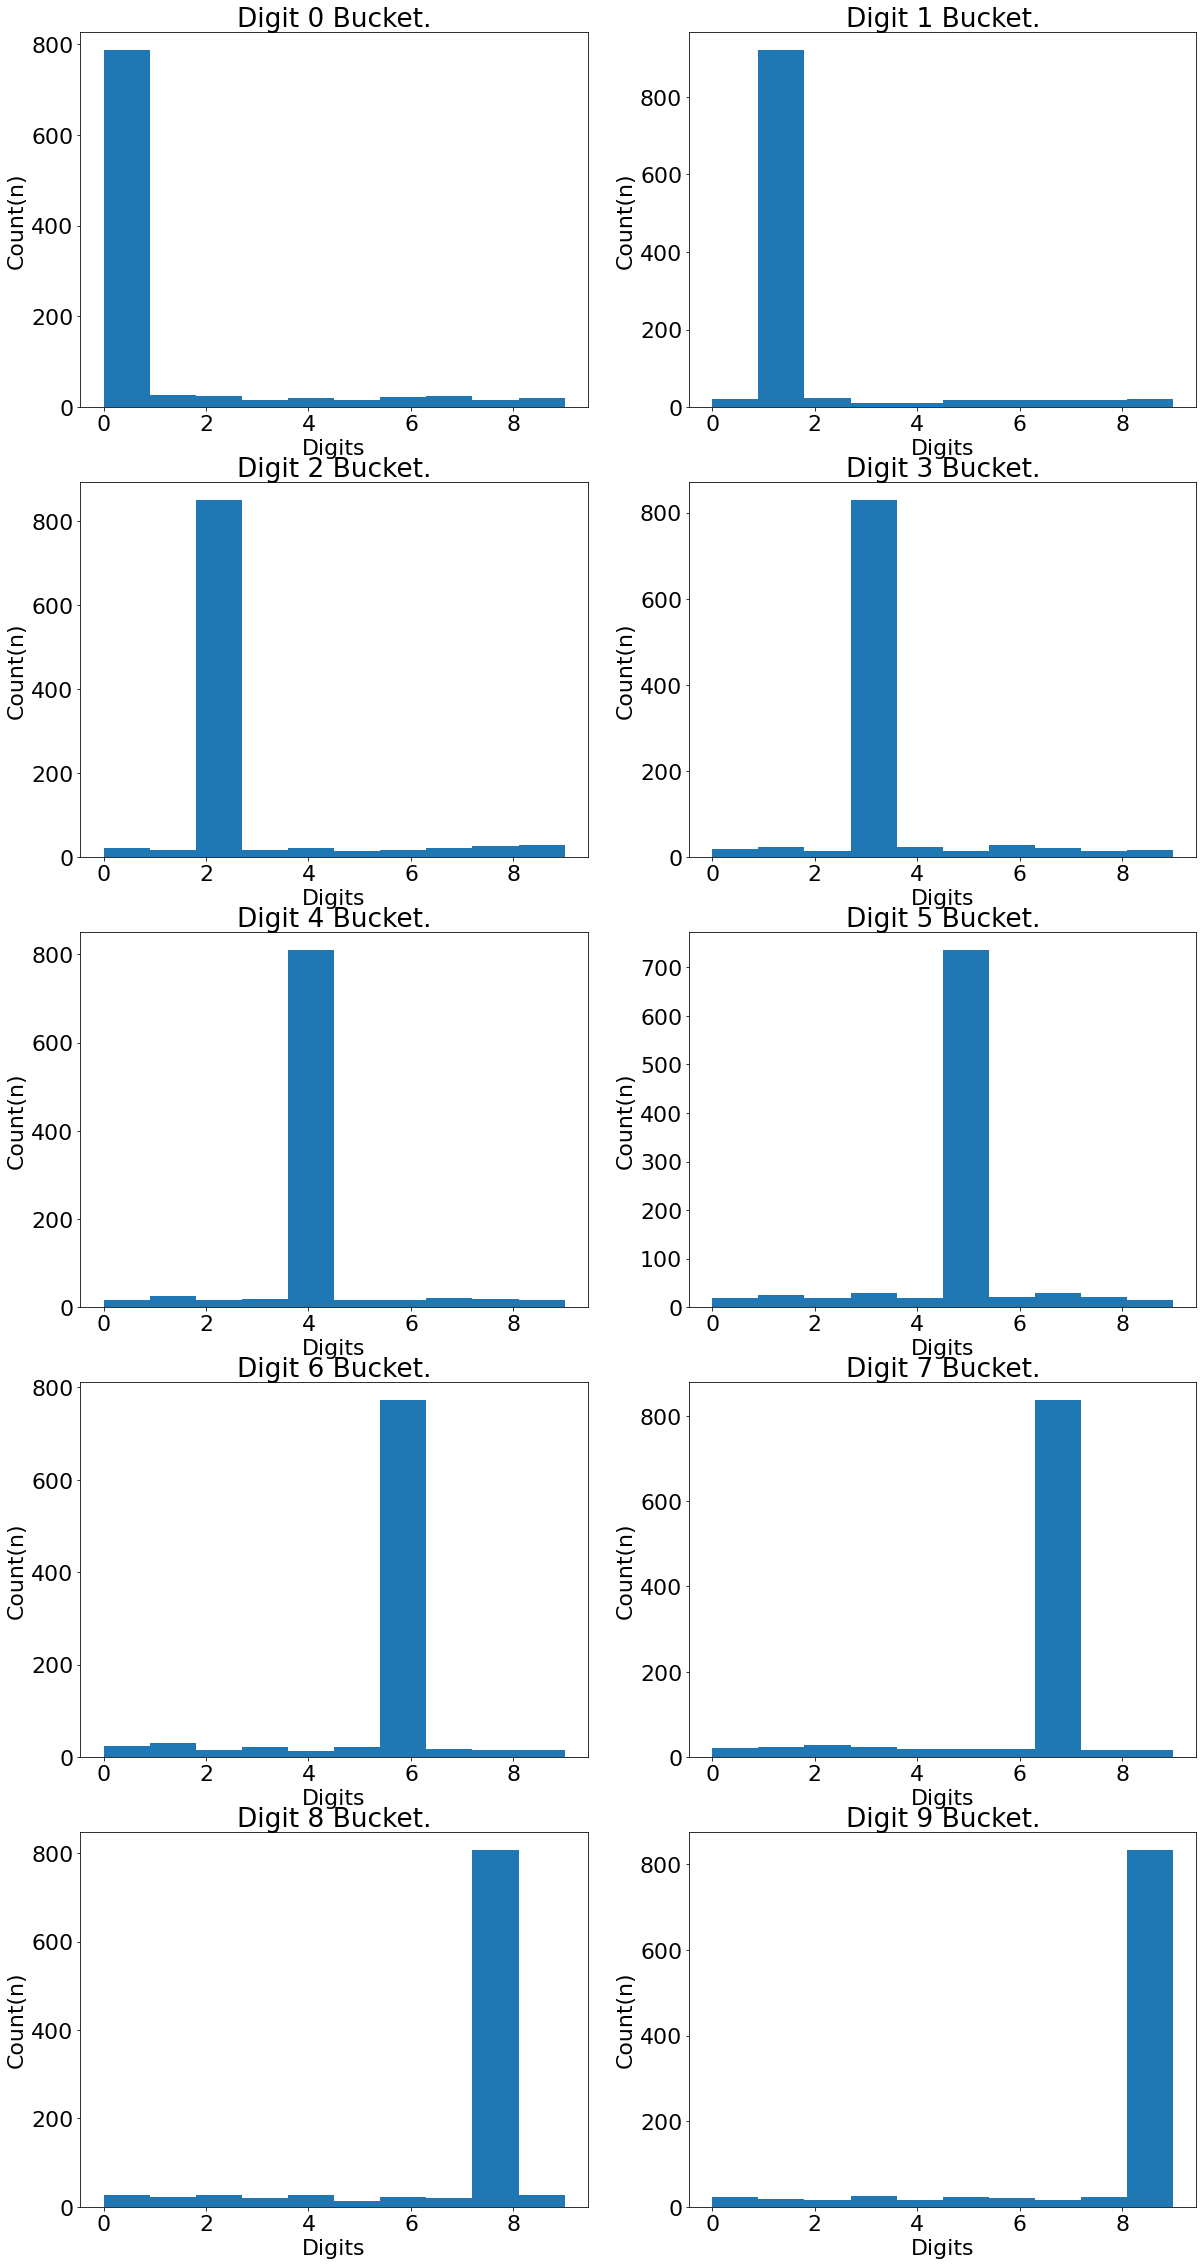

In [5]:
fig1, axs = plt.subplots(5,2, figsize=(20,40))
for row in range(5):
    for col in range(2):
        axs[row, col].hist(partitioned_test_arrays[row*2+col][1])
        axs[row, col].set_title('Digit {} Bucket.'.format(row*2+col))
        axs[row, col].set(xlabel='Digits', ylabel='Count(n)')

In [6]:
def create_keras_model():
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(28, kernel_size=(5,5),input_shape=input_shape),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(14, kernel_size=(5,5)),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128,activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(84,activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])

'numpy_partitioned_train_arrays' is dictionary with 10 keys corresponding to 0,1, ..., 9 digits.

In [7]:
def local_train(model, model_index, partitioned_train_arrays, partitioned_test_arrays, x_test, y_test, train_sample_count=100):
    x_train_reshaped = partitioned_train_arrays[model_index][0].reshape(-1,28,28,1)
    y_train_reshaped = partitioned_train_arrays[model_index][1]

    random_rows = np.random.choice(x_train_reshaped.shape[0], train_sample_count, replace=False)

    x_train_partitioned = x_train_reshaped[random_rows,:]
    y_train_partitioned = y_train_reshaped[random_rows]
    model.fit(x=x_train_partitioned, y=y_train_partitioned, epochs=1)
    
    x_test_partitioned = partitioned_test_arrays[model_index][0].reshape(-1,28,28,1)
    y_test_partitioned = partitioned_test_arrays[model_index][1]
    
    train_accuracy = model.evaluate(x_train_partitioned, y_train_partitioned)
    local_test_acciracy = model.evaluate(x_test_partitioned.reshape(-1,28,28,1), y_test_partitioned)
    global_test_accuracy = model.evaluate(x_test.reshape(-1,28,28,1), y_test)
    
    print('Accuracies: Training={}, Local Test={}, Global Test={}'.format(train_accuracy[1], local_test_acciracy[1], global_test_accuracy[1]))
    return(model, train_accuracy, local_test_acciracy, global_test_accuracy)
    

In [8]:
def average_models_weights(models_collection):
    '''
    '''
    
    weights = [models_collection[model].get_weights() for model in models_collection]

    new_weights = copy.copy(np.array(weights).mean(axis=0, out=None))

    new_model = create_keras_model()
    new_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    new_model.set_weights(new_weights)
    
    return(new_model)

## Regular Training (Non-Federated)

In [14]:
model_global = create_keras_model()
model_global.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])
print('total model layers', np.shape(model_global.layers))

models_collection = {}
experiment_prefix = 'regular_'
    
training_round = 100
training_round_accuracies_regular = []
train_sample_count=1000
digits_to_train = 2

for item in range(digits_to_train):
    models_collection['model_{}'.format(item)] = 0
    tf.keras.models.save_model(model=model_global, filepath='{}model_{}'.format(experiment_prefix,item))

for iteration in range(training_round):
    print('Starting iteration: {}'.format(iteration))

    models_accuracies = []
    for model in range(digits_to_train):
        current_model = tf.keras.models.load_model('{}model_{}'.format(experiment_prefix,model))
        #models_collection[model].compile(optimizer='adam',
        #    loss='sparse_categorical_crossentropy',
        #    metrics=['accuracy'])
        results = local_train(model=current_model,
                        model_index=int(model),
                        partitioned_train_arrays=partitioned_train_arrays,
                        partitioned_test_arrays=partitioned_test_arrays,
                        x_test = x_test,
                        y_test = y_test,
                        train_sample_count=train_sample_count)
        #print(model,models_collection['model_0'].get_weights()[0][0][0][0][0])
        #print(model,models_collection['model_1'].get_weights()[0][0][0][0][0])
        #models_collection[model] = tf.keras.models.clone_model(results[0])
        tf.keras.models.save_model(results[0], filepath='{}model_{}'.format(experiment_prefix,model))
        model_accuracies = [results[1][1], results[2][1], results[3][1]]
        models_accuracies.append(model_accuracies)

    training_round_accuracies_regular.append(models_accuracies)

    
    print('Finieshed iteration: {}'.format(iteration))
    
    

total model layers (10,)
INFO:tensorflow:Assets written to: regular_model_0/assets
INFO:tensorflow:Assets written to: regular_model_1/assets
Starting iteration: 0
313/313 [==============================] - 3s 9ms/step - loss: 8.6026 - accuracy: 0.3197
Accuracies: Training=0.8640000224113464, Local Test=0.8534836173057556, Global Test=0.3197000026702881
INFO:tensorflow:Assets written to: regular_model_0/assets
313/313 [==============================] - 2s 7ms/step - loss: 7.6491 - accuracy: 0.4123
Accuracies: Training=0.8899999856948853, Local Test=0.9032257795333862, Global Test=0.4122999906539917
INFO:tensorflow:Assets written to: regular_model_1/assets
Finieshed iteration: 0
Starting iteration: 1
313/313 [==============================] - 2s 7ms/step - loss: 4.5971 - accuracy: 0.3774
Accuracies: Training=0.8859999775886536, Local Test=0.8627049326896667, Global Test=0.3774000108242035
INFO:tensorflow:Assets written to: regular_model_0/assets
313/313 [==============================] -

313/313 [==============================] - 2s 6ms/step - loss: 1.9869 - accuracy: 0.5947
Accuracies: Training=0.9449999928474426, Local Test=0.9281105995178223, Global Test=0.5946999788284302
INFO:tensorflow:Assets written to: regular_model_1/assets
Finieshed iteration: 7
Starting iteration: 8
313/313 [==============================] - 3s 9ms/step - loss: 1.5565 - accuracy: 0.6067
Accuracies: Training=0.9340000152587891, Local Test=0.9006147384643555, Global Test=0.6067000031471252
INFO:tensorflow:Assets written to: regular_model_0/assets
313/313 [==============================] - 2s 7ms/step - loss: 1.6647 - accuracy: 0.6267
Accuracies: Training=0.9350000023841858, Local Test=0.9364055395126343, Global Test=0.6266999840736389
INFO:tensorflow:Assets written to: regular_model_1/assets
Finieshed iteration: 8
Starting iteration: 9
313/313 [==============================] - 2s 7ms/step - loss: 1.5707 - accuracy: 0.6089
Accuracies: Training=0.9399999976158142, Local Test=0.9077869057655334,

313/313 [==============================] - 2s 6ms/step - loss: 1.3404 - accuracy: 0.6409
Accuracies: Training=0.9430000185966492, Local Test=0.9211065769195557, Global Test=0.6409000158309937
INFO:tensorflow:Assets written to: regular_model_0/assets
313/313 [==============================] - 2s 6ms/step - loss: 1.5738 - accuracy: 0.6597
Accuracies: Training=0.9599999785423279, Local Test=0.9511520862579346, Global Test=0.6596999764442444
INFO:tensorflow:Assets written to: regular_model_1/assets
Finieshed iteration: 15
Starting iteration: 16
313/313 [==============================] - 2s 6ms/step - loss: 1.5484 - accuracy: 0.7171
Accuracies: Training=0.9679999947547913, Local Test=0.9446721076965332, Global Test=0.7171000242233276
INFO:tensorflow:Assets written to: regular_model_0/assets
313/313 [==============================] - 2s 6ms/step - loss: 1.2491 - accuracy: 0.6900
Accuracies: Training=0.9509999752044678, Local Test=0.9419354796409607, Global Test=0.6899999976158142
INFO:tensor

313/313 [==============================] - 2s 6ms/step - loss: 1.2713 - accuracy: 0.7386
Accuracies: Training=0.968999981880188, Local Test=0.9658986330032349, Global Test=0.7386000156402588
INFO:tensorflow:Assets written to: regular_model_1/assets
Finieshed iteration: 22
Starting iteration: 23
313/313 [==============================] - 2s 7ms/step - loss: 1.0804 - accuracy: 0.6628
Accuracies: Training=0.9419999718666077, Local Test=0.9252049326896667, Global Test=0.6628000140190125
INFO:tensorflow:Assets written to: regular_model_0/assets
313/313 [==============================] - 2s 6ms/step - loss: 1.2491 - accuracy: 0.7066
Accuracies: Training=0.9539999961853027, Local Test=0.9502304196357727, Global Test=0.70660001039505
INFO:tensorflow:Assets written to: regular_model_1/assets
Finieshed iteration: 23
Starting iteration: 24
313/313 [==============================] - 2s 7ms/step - loss: 1.2160 - accuracy: 0.6798
Accuracies: Training=0.9490000009536743, Local Test=0.9405737519264221

INFO:tensorflow:Assets written to: regular_model_0/assets
313/313 [==============================] - 2s 6ms/step - loss: 1.0348 - accuracy: 0.7756
Accuracies: Training=0.9700000286102295, Local Test=0.964976966381073, Global Test=0.775600016117096
INFO:tensorflow:Assets written to: regular_model_1/assets
Finieshed iteration: 30
Starting iteration: 31
313/313 [==============================] - 2s 6ms/step - loss: 1.0163 - accuracy: 0.7271
Accuracies: Training=0.972000002861023, Local Test=0.9395492076873779, Global Test=0.7271000146865845
INFO:tensorflow:Assets written to: regular_model_0/assets
313/313 [==============================] - 2s 6ms/step - loss: 0.9784 - accuracy: 0.7991
Accuracies: Training=0.9750000238418579, Local Test=0.9677419066429138, Global Test=0.7990999817848206
INFO:tensorflow:Assets written to: regular_model_1/assets
Finieshed iteration: 31
Starting iteration: 32
313/313 [==============================] - 2s 6ms/step - loss: 0.9243 - accuracy: 0.7064
Accuracies: 

313/313 [==============================] - 2s 6ms/step - loss: 1.0902 - accuracy: 0.6861
Accuracies: Training=0.9459999799728394, Local Test=0.9303278923034668, Global Test=0.6861000061035156
INFO:tensorflow:Assets written to: regular_model_0/assets
313/313 [==============================] - 2s 6ms/step - loss: 1.2642 - accuracy: 0.8013
Accuracies: Training=0.9789999723434448, Local Test=0.973271906375885, Global Test=0.8012999892234802
INFO:tensorflow:Assets written to: regular_model_1/assets
Finieshed iteration: 38
Starting iteration: 39
313/313 [==============================] - 2s 6ms/step - loss: 0.8608 - accuracy: 0.7593
Accuracies: Training=0.9449999928474426, Local Test=0.9497950673103333, Global Test=0.7592999935150146
INFO:tensorflow:Assets written to: regular_model_0/assets
313/313 [==============================] - 2s 5ms/step - loss: 1.6878 - accuracy: 0.7453
Accuracies: Training=0.9629999995231628, Local Test=0.9520737528800964, Global Test=0.7452999949455261
INFO:tensorf

313/313 [==============================] - 2s 6ms/step - loss: 0.9717 - accuracy: 0.7700
Accuracies: Training=0.9739999771118164, Local Test=0.9686635732650757, Global Test=0.7699999809265137
INFO:tensorflow:Assets written to: regular_model_1/assets
Finieshed iteration: 45
Starting iteration: 46
313/313 [==============================] - 2s 7ms/step - loss: 0.9812 - accuracy: 0.8044
Accuracies: Training=0.9670000076293945, Local Test=0.9579917788505554, Global Test=0.8044000267982483
INFO:tensorflow:Assets written to: regular_model_0/assets
313/313 [==============================] - 2s 6ms/step - loss: 1.3877 - accuracy: 0.7284
Accuracies: Training=0.9549999833106995, Local Test=0.9548386931419373, Global Test=0.7283999919891357
INFO:tensorflow:Assets written to: regular_model_1/assets
Finieshed iteration: 46
Starting iteration: 47
313/313 [==============================] - 2s 6ms/step - loss: 1.3198 - accuracy: 0.7066
Accuracies: Training=0.953000009059906, Local Test=0.94159835577011

INFO:tensorflow:Assets written to: regular_model_0/assets
313/313 [==============================] - 2s 6ms/step - loss: 1.6015 - accuracy: 0.7245
Accuracies: Training=0.9639999866485596, Local Test=0.9511520862579346, Global Test=0.7245000004768372
INFO:tensorflow:Assets written to: regular_model_1/assets
Finieshed iteration: 53
Starting iteration: 54
313/313 [==============================] - 2s 6ms/step - loss: 1.5183 - accuracy: 0.7870
Accuracies: Training=0.972000002861023, Local Test=0.9600409865379333, Global Test=0.7870000004768372
INFO:tensorflow:Assets written to: regular_model_0/assets
313/313 [==============================] - 2s 6ms/step - loss: 1.0261 - accuracy: 0.7977
Accuracies: Training=0.9739999771118164, Local Test=0.9705069065093994, Global Test=0.7976999878883362
INFO:tensorflow:Assets written to: regular_model_1/assets
Finieshed iteration: 54
Starting iteration: 55
313/313 [==============================] - 2s 6ms/step - loss: 1.2918 - accuracy: 0.7572
Accuracies

313/313 [==============================] - 2s 6ms/step - loss: 2.3324 - accuracy: 0.6788
Accuracies: Training=0.9440000057220459, Local Test=0.931352436542511, Global Test=0.6787999868392944
INFO:tensorflow:Assets written to: regular_model_0/assets
313/313 [==============================] - 2s 6ms/step - loss: 0.9675 - accuracy: 0.8237
Accuracies: Training=0.9750000238418579, Local Test=0.9723502397537231, Global Test=0.8237000107765198
INFO:tensorflow:Assets written to: regular_model_1/assets
Finieshed iteration: 61
Starting iteration: 62
313/313 [==============================] - 2s 5ms/step - loss: 1.6103 - accuracy: 0.7707
Accuracies: Training=0.9710000157356262, Local Test=0.9518442749977112, Global Test=0.7706999778747559
INFO:tensorflow:Assets written to: regular_model_0/assets
313/313 [==============================] - 2s 6ms/step - loss: 1.5459 - accuracy: 0.7777
Accuracies: Training=0.949999988079071, Local Test=0.9364055395126343, Global Test=0.7777000069618225
INFO:tensorfl

313/313 [==============================] - 2s 6ms/step - loss: 1.6079 - accuracy: 0.7830
Accuracies: Training=0.9779999852180481, Local Test=0.9612902998924255, Global Test=0.7829999923706055
INFO:tensorflow:Assets written to: regular_model_1/assets
Finieshed iteration: 68
Starting iteration: 69
313/313 [==============================] - 2s 6ms/step - loss: 1.0952 - accuracy: 0.7790
Accuracies: Training=0.9599999785423279, Local Test=0.9487704634666443, Global Test=0.7789999842643738
INFO:tensorflow:Assets written to: regular_model_0/assets
313/313 [==============================] - 2s 7ms/step - loss: 1.5089 - accuracy: 0.7920
Accuracies: Training=0.972000002861023, Local Test=0.9668202996253967, Global Test=0.7919999957084656
INFO:tensorflow:Assets written to: regular_model_1/assets
Finieshed iteration: 69
Starting iteration: 70
313/313 [==============================] - 2s 6ms/step - loss: 1.2124 - accuracy: 0.7650
Accuracies: Training=0.9710000157356262, Local Test=0.94979506731033

313/313 [==============================] - 2s 6ms/step - loss: 3.5503 - accuracy: 0.7811
Accuracies: Training=0.9810000061988831, Local Test=0.9590163826942444, Global Test=0.7810999751091003
INFO:tensorflow:Assets written to: regular_model_0/assets
313/313 [==============================] - 2s 6ms/step - loss: 1.5583 - accuracy: 0.5773
Accuracies: Training=0.9430000185966492, Local Test=0.9253455996513367, Global Test=0.5773000121116638
INFO:tensorflow:Assets written to: regular_model_1/assets
Finieshed iteration: 76
Starting iteration: 77
313/313 [==============================] - 2s 6ms/step - loss: 1.2092 - accuracy: 0.8134
Accuracies: Training=0.9729999899864197, Local Test=0.9569672346115112, Global Test=0.8133999705314636
INFO:tensorflow:Assets written to: regular_model_0/assets
313/313 [==============================] - 2s 6ms/step - loss: 0.9600 - accuracy: 0.7814
Accuracies: Training=0.9700000286102295, Local Test=0.9631336331367493, Global Test=0.7814000248908997
INFO:tensor

INFO:tensorflow:Assets written to: regular_model_1/assets
Finieshed iteration: 83
Starting iteration: 84
313/313 [==============================] - 2s 5ms/step - loss: 1.0911 - accuracy: 0.8261
Accuracies: Training=0.9639999866485596, Local Test=0.9559426307678223, Global Test=0.8260999917984009
INFO:tensorflow:Assets written to: regular_model_0/assets
313/313 [==============================] - 2s 6ms/step - loss: 1.6003 - accuracy: 0.7810
Accuracies: Training=0.9679999947547913, Local Test=0.9529954195022583, Global Test=0.781000018119812
INFO:tensorflow:Assets written to: regular_model_1/assets
Finieshed iteration: 84
Starting iteration: 85
313/313 [==============================] - 2s 5ms/step - loss: 3.0389 - accuracy: 0.8106
Accuracies: Training=0.984000027179718, Local Test=0.9610655903816223, Global Test=0.8105999827384949
INFO:tensorflow:Assets written to: regular_model_0/assets
313/313 [==============================] - 2s 5ms/step - loss: 1.5618 - accuracy: 0.7453
Accuracies:

313/313 [==============================] - 2s 6ms/step - loss: 2.1583 - accuracy: 0.6941
Accuracies: Training=0.9539999961853027, Local Test=0.9474654197692871, Global Test=0.694100022315979
INFO:tensorflow:Assets written to: regular_model_1/assets
Finieshed iteration: 91
Starting iteration: 92
313/313 [==============================] - 2s 6ms/step - loss: 1.5861 - accuracy: 0.7789
Accuracies: Training=0.9639999866485596, Local Test=0.9487704634666443, Global Test=0.7789000272750854
INFO:tensorflow:Assets written to: regular_model_0/assets
313/313 [==============================] - 2s 6ms/step - loss: 1.2059 - accuracy: 0.7931
Accuracies: Training=0.9670000076293945, Local Test=0.9603686928749084, Global Test=0.7930999994277954
INFO:tensorflow:Assets written to: regular_model_1/assets
Finieshed iteration: 92
Starting iteration: 93
313/313 [==============================] - 3s 10ms/step - loss: 2.1158 - accuracy: 0.7826
Accuracies: Training=0.9710000157356262, Local Test=0.9579917788505

313/313 [==============================] - 2s 6ms/step - loss: 2.6850 - accuracy: 0.6759
Accuracies: Training=0.9549999833106995, Local Test=0.9293032884597778, Global Test=0.6758999824523926
INFO:tensorflow:Assets written to: regular_model_0/assets
313/313 [==============================] - 2s 6ms/step - loss: 1.9465 - accuracy: 0.7884
Accuracies: Training=0.9789999723434448, Local Test=0.9594470262527466, Global Test=0.7883999943733215
INFO:tensorflow:Assets written to: regular_model_1/assets
Finieshed iteration: 99


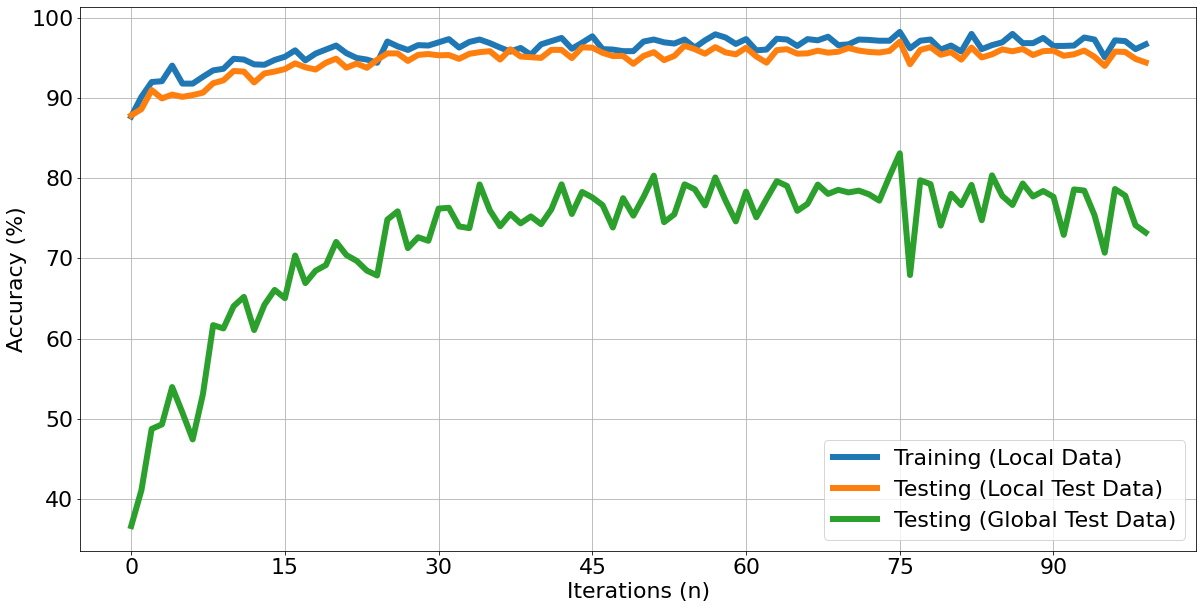

In [15]:
fig2, ax1 = plt.subplots(1,1, figsize=(20,10))
plt.plot(np.array(training_round_accuracies_regular).mean(axis=1)*100, linewidth=6)
plt.grid()
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_xlabel('Iterations (n)')
ax1.set_ylabel('Accuracy (%)')
ax1.legend(('Training (Local Data)', 'Testing (Local Test Data)', 'Testing (Global Test Data)'))



## Federated Learning

In [ ]:
model_global = create_keras_model()
model_global.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])
print('total model layers', np.shape(model_global.layers))

models_collection = {}
experiment_prefix = 'federated_'
digits_to_train = 2
for item in range(digits_to_train):
    models_collection['model_{}'.format(item)] = 0
    tf.keras.models.save_model(model=model_global, filepath='{}model_{}'.format(experiment_prefix,item))
    


training_round = 50
training_round_accuracies_federated_learning = []
train_sample_count=1000

for iteration in range(training_round):
    print('Starting iteration: {}'.format(iteration))

    models_accuracies = []
    for model in range(digits_to_train):
        #models_collection[model].compile(optimizer='adam',
        #    loss='sparse_categorical_crossentropy',
        #    metrics=['accuracy'])
        current_model = tf.keras.models.load_model('{}model_{}'.format(experiment_prefix,item))
        results = local_train(model=current_model,
                        model_index=int(model),#int(model.strip('model_')),
                        partitioned_train_arrays=partitioned_train_arrays,
                        partitioned_test_arrays=partitioned_test_arrays,
                        x_test = x_test,
                        y_test = y_test,
                        train_sample_count=train_sample_count)
        
        '''
        Exteremely important to use "tf.keras.models.clone_model(results[0])" in the next
        line. Even copy.copy(results[0]) would produce a referenced model with the same weights/
        ''' 
        #print(model,models_collection['model_0'].get_weights()[0][0][0][0][0])
        #print(model,models_collection['model_1'].get_weights()[0][0][0][0][0])
        #models_collection[model] = tf.keras.models.clone_model(results[0])
        #print('Model {} updated!'.format(model))
        tf.keras.models.save_model(results[0], filepath='{}model_{}'.format(experiment_prefix,model))
        model_accuracies = [results[1][1], results[2][1], results[3][1]]
        models_accuracies.append(model_accuracies)

    training_round_accuracies_federated_learning.append(models_accuracies)
    print('Averaging Models')
    

    models_collection = {}
    for item in range(digits_to_train):
        models_collection['model_{}'.format(item)] = tf.keras.models.load_model('{}model_{}'.format(experiment_prefix,item))

    model_global = copy.copy(average_models_weights(models_collection))
    print('total model layers', np.shape(model_global.layers))

    models_collection = {}
    for item in range(digits_to_train):
        tf.keras.models.save_model(model_global, filepath='{}model_{}'.format(experiment_prefix,item))
        #models_collection['model_{}'.format(item)] = copy.copy(model_global)
    #print('Model Memory IDs: {}, {}'.format(id(models_collection['model_0']),id(models_collection['model_1'])))
    
    print('Finieshed iteration: {}'.format(iteration))
    
    

In [ ]:
fig2, ax1 = plt.subplots(1,1, figsize=(20,10))
plt.plot(np.array(training_round_accuracies_federated_learning).mean(axis=1)*100, linewidth=6)
plt.grid()
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_xlabel('Iterations (n)')
ax1.set_ylabel('Accuracy (%)')
ax1.legend(('Training (Local Data)', 'Testing (Local Test Data)', 'Testing (Global Test Data)'))



In [ ]:
len(training_round_accuracies_federated_learning)

## Federated Learning with Fine-Tuning

In [12]:
model_global = create_keras_model()
model_global.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])
print('total model layers', np.shape(model_global.layers))

models_collection = {}
experiment_prefix = 'federated_finetune'
digits_to_train = 2
for item in range(digits_to_train):
    models_collection['model_{}'.format(item)] = 0
    tf.keras.models.save_model(model=model_global, filepath='{}model_{}'.format(experiment_prefix,item))
    


training_round = 50
training_round_accuracies_finetuned = []
train_sample_count=1000

for iteration in range(training_round):
    print('Starting iteration: {}'.format(iteration))

    models_accuracies = []
    for model in range(digits_to_train):
        #models_collection[model].compile(optimizer='adam',
        #    loss='sparse_categorical_crossentropy',
        #    metrics=['accuracy'])
        current_model = tf.keras.models.load_model('{}model_{}'.format(experiment_prefix,item))
        results = local_train(model=current_model,
                        model_index=int(model),#int(model.strip('model_')),
                        partitioned_train_arrays=partitioned_train_arrays,
                        partitioned_test_arrays=partitioned_test_arrays,
                        x_test = x_test,
                        y_test = y_test,
                        train_sample_count=train_sample_count)
        
        '''
        Exteremely important to use "tf.keras.models.clone_model(results[0])" in the next
        line. Even copy.copy(results[0]) would produce a referenced model with the same weights/
        ''' 
        #print(model,models_collection['model_0'].get_weights()[0][0][0][0][0])
        #print(model,models_collection['model_1'].get_weights()[0][0][0][0][0])
        #models_collection[model] = tf.keras.models.clone_model(results[0])
        #print('Model {} updated!'.format(model))
        tf.keras.models.save_model(results[0], filepath='{}model_{}'.format(experiment_prefix,model))
        model_accuracies = [results[1][1], results[2][1], results[3][1]]
        models_accuracies.append(model_accuracies)

    training_round_accuracies_finetuned.append(models_accuracies)
    print('Averaging Models')
    

    if(iteration<40):
    
        models_collection = {}
        for item in range(digits_to_train):
            models_collection['model_{}'.format(item)] = tf.keras.models.load_model('{}model_{}'.format(experiment_prefix,item))

        model_global = copy.copy(average_models_weights(models_collection))
        print('total model layers', np.shape(model_global.layers))

        models_collection = {}
        for item in range(digits_to_train):
            tf.keras.models.save_model(model_global, filepath='{}model_{}'.format(experiment_prefix,item))
            #models_collection['model_{}'.format(item)] = copy.copy(model_global)
        #print('Model Memory IDs: {}, {}'.format(id(models_collection['model_0']),id(models_collection['model_1'])))
    else:
        pass
    
    print('Finieshed iteration: {}'.format(iteration))
    
    











# model_global = create_keras_model()
# model_global.compile(optimizer='adam',
# loss='sparse_categorical_crossentropy',
# metrics=['accuracy'])
# print('total model layers', np.shape(model_global.layers))

# models_collection = {}
# for item in range(10):
#     models_collection['model_{}'.format(item)] = tf.keras.models.clone_model(model_global)
    


# training_round = 50
# training_round_accuracies_finetuned = []
# train_sample_count= 25
# for iteration in range(training_round):
#     print('Starting iteration: {}'.format(iteration))

#     models_accuracies = []
#     for model in models_collection:
#         models_collection[model].compile(optimizer='adam',
#              loss='sparse_categorical_crossentropy',
#              metrics=['accuracy'])
#         results = local_train(model=models_collection[model],
#                         model_index=int(model.strip('model_')),
#                         partitioned_train_arrays=partitioned_train_arrays,
#                         partitioned_test_arrays=partitioned_test_arrays,
#                         x_test = x_test,
#                         y_test = y_test,
#                         train_sample_count=train_sample_count)
#         '''
#         Exteremely important to use "tf.keras.models.clone_model(results[0])" in the next
#         line. Even copy.copy(results[0]) would produce a referenced model with the same weights/
#         ''' 
#         models_collection[model] = tf.keras.models.clone_model(results[0])
        
#         print(model,models_collection['model_0'].get_weights()[0][0][0][0][0])
#         print(model,models_collection['model_1'].get_weights()[0][0][0][0][0])
#         model_accuracies = [results[1][1], results[2][1], results[3][1]]
#         models_accuracies.append(model_accuracies)

#     training_round_accuracies_finetuned.append(models_accuracies)
#     print('Averaging Models')
    
#     if(iteration<10):
#         model_global = average_models_weights(models_collection)
#         print('total model layers', np.shape(model_global.layers))

#         models_collection = {}
#         for item in range(10):
#             models_collection['model_{}'.format(item)] = model_global
#     else:
#         pass
    
#     print('Finieshed iteration: {}'.format(iteration))
    
    

total model layers (10,)
INFO:tensorflow:Assets written to: federated_finetunemodel_0/assets
INFO:tensorflow:Assets written to: federated_finetunemodel_1/assets
Starting iteration: 0
313/313 [==============================] - 2s 7ms/step - loss: 5.5153 - accuracy: 0.4002
Accuracies: Training=0.8560000061988831, Local Test=0.8565573692321777, Global Test=0.4002000093460083
INFO:tensorflow:Assets written to: federated_finetunemodel_0/assets
313/313 [==============================] - 2s 7ms/step - loss: 7.3250 - accuracy: 0.3670
Accuracies: Training=0.9110000133514404, Local Test=0.8930875658988953, Global Test=0.367000013589859
INFO:tensorflow:Assets written to: federated_finetunemodel_1/assets
Averaging Models
total model layers (10,)
INFO:tensorflow:Assets written to: federated_finetunemodel_0/assets
INFO:tensorflow:Assets written to: federated_finetunemodel_1/assets
Finieshed iteration: 0
Starting iteration: 1
313/313 [==============================] - 3s 9ms/step - loss: 4.0158 - acc

INFO:tensorflow:Assets written to: federated_finetunemodel_0/assets
313/313 [==============================] - 2s 6ms/step - loss: 2.8690 - accuracy: 0.5350
Accuracies: Training=0.9279999732971191, Local Test=0.9161290526390076, Global Test=0.5350000262260437
INFO:tensorflow:Assets written to: federated_finetunemodel_1/assets
Averaging Models
total model layers (10,)
INFO:tensorflow:Assets written to: federated_finetunemodel_0/assets
INFO:tensorflow:Assets written to: federated_finetunemodel_1/assets
Finieshed iteration: 6
Starting iteration: 7
313/313 [==============================] - 2s 7ms/step - loss: 1.5338 - accuracy: 0.6639
Accuracies: Training=0.9419999718666077, Local Test=0.9252049326896667, Global Test=0.6639000177383423
INFO:tensorflow:Assets written to: federated_finetunemodel_0/assets
313/313 [==============================] - 2s 7ms/step - loss: 1.4704 - accuracy: 0.6095
Accuracies: Training=0.9419999718666077, Local Test=0.9290322661399841, Global Test=0.60949999094009

Averaging Models
total model layers (10,)
INFO:tensorflow:Assets written to: federated_finetunemodel_0/assets
INFO:tensorflow:Assets written to: federated_finetunemodel_1/assets
Finieshed iteration: 12
Starting iteration: 13
313/313 [==============================] - 2s 7ms/step - loss: 0.9253 - accuracy: 0.7757
Accuracies: Training=0.9580000042915344, Local Test=0.9323770403862, Global Test=0.7756999731063843
INFO:tensorflow:Assets written to: federated_finetunemodel_0/assets
313/313 [==============================] - 2s 6ms/step - loss: 1.0845 - accuracy: 0.7431
Accuracies: Training=0.9760000109672546, Local Test=0.956682026386261, Global Test=0.7430999875068665
INFO:tensorflow:Assets written to: federated_finetunemodel_1/assets
Averaging Models
total model layers (10,)
INFO:tensorflow:Assets written to: federated_finetunemodel_0/assets
INFO:tensorflow:Assets written to: federated_finetunemodel_1/assets
Finieshed iteration: 13
Starting iteration: 14
313/313 [=========================

INFO:tensorflow:Assets written to: federated_finetunemodel_0/assets
313/313 [==============================] - 2s 6ms/step - loss: 1.0249 - accuracy: 0.7565
Accuracies: Training=0.9649999737739563, Local Test=0.9557603597640991, Global Test=0.7565000057220459
INFO:tensorflow:Assets written to: federated_finetunemodel_1/assets
Averaging Models
total model layers (10,)
INFO:tensorflow:Assets written to: federated_finetunemodel_0/assets
INFO:tensorflow:Assets written to: federated_finetunemodel_1/assets
Finieshed iteration: 19
Starting iteration: 20
313/313 [==============================] - 2s 6ms/step - loss: 1.1331 - accuracy: 0.7480
Accuracies: Training=0.9620000123977661, Local Test=0.9467213153839111, Global Test=0.7480000257492065
INFO:tensorflow:Assets written to: federated_finetunemodel_0/assets
313/313 [==============================] - 2s 8ms/step - loss: 1.0556 - accuracy: 0.7915
Accuracies: Training=0.9829999804496765, Local Test=0.9686635732650757, Global Test=0.791499972343

Averaging Models
total model layers (10,)
INFO:tensorflow:Assets written to: federated_finetunemodel_0/assets
INFO:tensorflow:Assets written to: federated_finetunemodel_1/assets
Finieshed iteration: 25
Starting iteration: 26
313/313 [==============================] - 2s 7ms/step - loss: 0.8790 - accuracy: 0.7978
Accuracies: Training=0.9539999961853027, Local Test=0.9569672346115112, Global Test=0.7978000044822693
INFO:tensorflow:Assets written to: federated_finetunemodel_0/assets
313/313 [==============================] - 2s 7ms/step - loss: 0.9461 - accuracy: 0.8111
Accuracies: Training=0.9789999723434448, Local Test=0.9760368466377258, Global Test=0.8111000061035156
INFO:tensorflow:Assets written to: federated_finetunemodel_1/assets
Averaging Models
total model layers (10,)
INFO:tensorflow:Assets written to: federated_finetunemodel_0/assets
INFO:tensorflow:Assets written to: federated_finetunemodel_1/assets
Finieshed iteration: 26
Starting iteration: 27
313/313 [=====================

INFO:tensorflow:Assets written to: federated_finetunemodel_0/assets
313/313 [==============================] - 4s 12ms/step - loss: 1.6198 - accuracy: 0.7075
Accuracies: Training=0.9710000157356262, Local Test=0.9557603597640991, Global Test=0.7074999809265137
INFO:tensorflow:Assets written to: federated_finetunemodel_1/assets
Averaging Models
total model layers (10,)
INFO:tensorflow:Assets written to: federated_finetunemodel_0/assets
INFO:tensorflow:Assets written to: federated_finetunemodel_1/assets
Finieshed iteration: 32
Starting iteration: 33
313/313 [==============================] - 2s 7ms/step - loss: 1.4018 - accuracy: 0.7993
Accuracies: Training=0.9769999980926514, Local Test=0.9672130942344666, Global Test=0.7993000149726868
INFO:tensorflow:Assets written to: federated_finetunemodel_0/assets
313/313 [==============================] - 2s 6ms/step - loss: 1.0935 - accuracy: 0.8038
Accuracies: Training=0.9700000286102295, Local Test=0.9612902998924255, Global Test=0.80379998683

Averaging Models
total model layers (10,)
INFO:tensorflow:Assets written to: federated_finetunemodel_0/assets
INFO:tensorflow:Assets written to: federated_finetunemodel_1/assets
Finieshed iteration: 38
Starting iteration: 39
313/313 [==============================] - 2s 6ms/step - loss: 1.2800 - accuracy: 0.8439
Accuracies: Training=0.984000027179718, Local Test=0.9682376980781555, Global Test=0.8439000248908997
INFO:tensorflow:Assets written to: federated_finetunemodel_0/assets
313/313 [==============================] - 2s 6ms/step - loss: 1.5315 - accuracy: 0.8063
Accuracies: Training=0.9769999980926514, Local Test=0.9668202996253967, Global Test=0.8062999844551086
INFO:tensorflow:Assets written to: federated_finetunemodel_1/assets
Averaging Models
total model layers (10,)
INFO:tensorflow:Assets written to: federated_finetunemodel_0/assets
INFO:tensorflow:Assets written to: federated_finetunemodel_1/assets
Finieshed iteration: 39
Starting iteration: 40
313/313 [======================

313/313 [==============================] - 2s 7ms/step - loss: 1.3490 - accuracy: 0.8076
Accuracies: Training=0.9729999899864197, Local Test=0.9661885499954224, Global Test=0.8076000213623047
INFO:tensorflow:Assets written to: federated_finetunemodel_0/assets
313/313 [==============================] - 3s 9ms/step - loss: 1.4791 - accuracy: 0.7471
Accuracies: Training=0.9739999771118164, Local Test=0.9640552997589111, Global Test=0.7470999956130981
INFO:tensorflow:Assets written to: federated_finetunemodel_1/assets
Averaging Models
Finieshed iteration: 46
Starting iteration: 47
313/313 [==============================] - 2s 7ms/step - loss: 1.0037 - accuracy: 0.8500
Accuracies: Training=0.9800000190734863, Local Test=0.9713114500045776, Global Test=0.8500000238418579
INFO:tensorflow:Assets written to: federated_finetunemodel_0/assets
313/313 [==============================] - 2s 6ms/step - loss: 2.9722 - accuracy: 0.7686
Accuracies: Training=0.972000002861023, Local Test=0.96774190664291

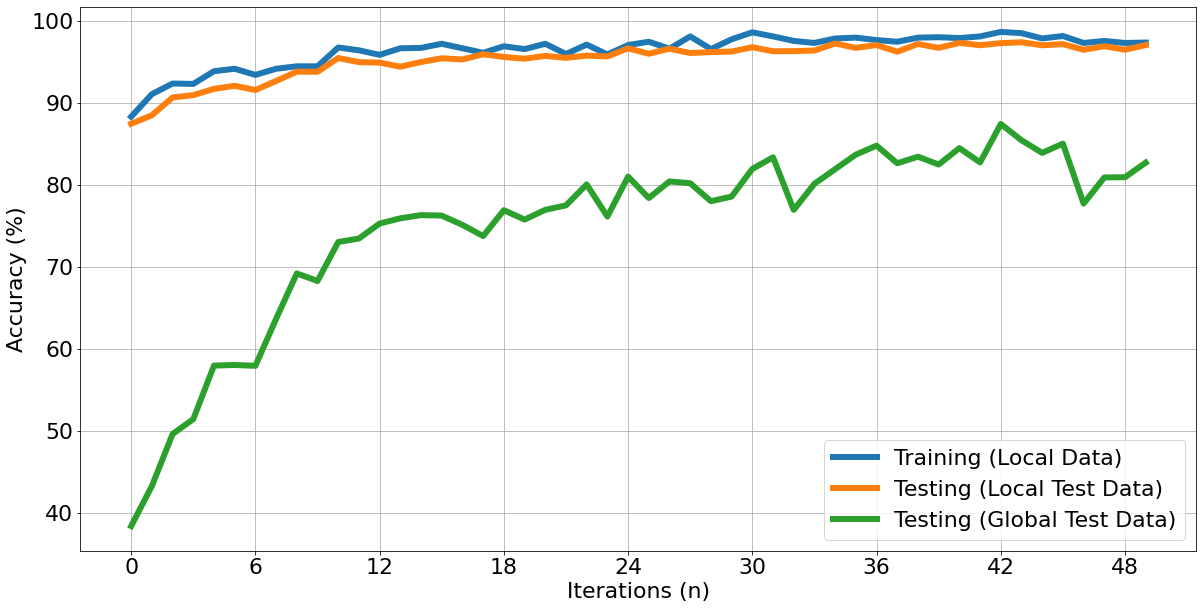

In [13]:
fig2, ax1 = plt.subplots(1,1, figsize=(20,10))
plt.plot(np.array(training_round_accuracies_finetuned).mean(axis=1)*100, linewidth=6)
plt.grid()
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_xlabel('Iterations (n)')
ax1.set_ylabel('Accuracy (%)')
ax1.legend(('Training (Local Data)', 'Testing (Local Test Data)', 'Testing (Global Test Data)'))

